# Cowper Pipeline

The following document explains and motivates the steps of this pipeline.
The following code block imports all relevant dependencies and loads the given data directory with all the raw RLU values.

In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from wellwellwell import ingest, normalizations, analyses, plots

dataset = ingest.read_well_wide_timeseries_folder("data/")
dataset

row,position,source,treatment,line_id,experiment,day,time,rlu,well,sample_id
str,i32,str,str,str,str,str,f32,i32,str,str
"""A""",1,"""sample_6""","""mock""","""Mock""","""A""","""25_4_2023""",0.0,20293,"""A1""","""sample_6_A1"""
"""A""",10,"""sample_6""","""mock""","""KOH""","""A""","""25_4_2023""",0.0,14262,"""A10""","""sample_6_A10"""
"""A""",11,"""sample_6""","""mock""","""KOH""","""A""","""25_4_2023""",0.0,7724,"""A11""","""sample_6_A11"""
"""A""",12,"""sample_6""","""mock""","""KOH""","""A""","""25_4_2023""",0.0,17470,"""A12""","""sample_6_A12"""
"""A""",2,"""sample_6""","""mock""","""Mock""","""A""","""25_4_2023""",0.0,6855,"""A2""","""sample_6_A2"""
"""A""",3,"""sample_6""","""mock""","""Mock""","""A""","""25_4_2023""",0.0,14874,"""A3""","""sample_6_A3"""
"""A""",4,"""sample_6""","""mock""","""Mock""","""A""","""25_4_2023""",0.0,26725,"""A4""","""sample_6_A4"""
"""A""",5,"""sample_6""","""mock""","""Mock""","""A""","""25_4_2023""",0.0,24727,"""A5""","""sample_6_A5"""
"""A""",6,"""sample_6""","""mock""","""Mock""","""A""","""25_4_2023""",0.0,34021,"""A6""","""sample_6_A6"""


# Normalizing to `rlu_dx`

Relative light units (or RLU) in principle can vary greatly in terms of measurements.
Even on a single well plate, you can have similarly treated samples start off with big differences (10-fold or even 100-fold).
These differences become even greater when you factor in tghat experiments are run on different days, which may inadvertently influence the measured values.

To deal with this, rather than looking at the raw RLU values, a `rlu_dx` is computed, which is the relative change to the `t=0`.
For a more concrete explanation, consider the following data:

```
sample_1 | 100  | 200  | 300
sample_2 | 1000 | 2000 | 3000
```

Biologically these sampels behave exactly the same over time, but their measured RLU is different.
Ideally we would normalize this to show `1 | 2 | 3` for both samples and we can do this by dividing each value by the initial measured value.
The code block below does exactly this for each sample.

In [2]:
normalized = normalizations.sample_rlu_dx(dataset)
normalized

row,position,source,treatment,line_id,experiment,day,time,rlu,well,sample_id,rlu_dx
str,i32,str,str,str,str,str,f32,i32,str,str,f64
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",0.0,462,"""B6""","""sample_2_B6""",1.0
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",2.5,2220,"""B6""","""sample_2_B6""",4.805195
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",5.0,6713,"""B6""","""sample_2_B6""",14.530303
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",7.5,7958,"""B6""","""sample_2_B6""",17.225108
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",10.0,9384,"""B6""","""sample_2_B6""",20.311688
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",12.5,11808,"""B6""","""sample_2_B6""",25.558442
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",15.0,13995,"""B6""","""sample_2_B6""",30.292208
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",17.5,15458,"""B6""","""sample_2_B6""",33.458874
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",20.0,16840,"""B6""","""sample_2_B6""",36.450216


# Normalizing `rlu_dx` with `log10`

Because of the eponential nature of RLU measurements, we apply a log transformation.
To determine the base of the log, we must look at the factors of how big the difference between values is.
The coe below extracts the minimum value and the maximum value from the dataset.

In [3]:
print(f"The highest value is {normalized['rlu_dx'].max()}")
print(f"The lowest value is {normalized['rlu_dx'].min()}")
if normalized['rlu_dx'].min() == 0:
    print("The lowest value is zero, so the fold change is infinite")
else:
    print(f"The difference between the highest and lowest value is x{normalized['rlu_dx'].max() / normalized['rlu_dx'].min()}")

The highest value is 358.42456896551727
The lowest value is 0.0
The lowest value is zero, so the fold change is infinite


Considering that difference is very big, it makes sense to apply a `log10` transformation for the data.
If the difference were ~25%, a natural log would be used. 
If the difference were less than 10, a `log2` would be used.

The code below applies the log transformation. 

In [4]:
normalized.replace("rlu_dx", normalized["rlu_dx"].log(base=10))
print(f"The highest value is {normalized['rlu_dx'].max()}")
print(f"The lowest value is {normalized['rlu_dx'].min()}")
print(f"The difference between the highest and lowest value is x{normalized['rlu_dx'].max() / normalized['rlu_dx'].min()}")
normalized

The highest value is 2.554397771638629
The lowest value is -inf
The difference between the highest and lowest value is x-0.0


row,position,source,treatment,line_id,experiment,day,time,rlu,well,sample_id,rlu_dx
str,i32,str,str,str,str,str,f32,i32,str,str,f64
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",0.0,462,"""B6""","""sample_2_B6""",0.0
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",2.5,2220,"""B6""","""sample_2_B6""",0.681711
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",5.0,6713,"""B6""","""sample_2_B6""",1.162275
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",7.5,7958,"""B6""","""sample_2_B6""",1.236162
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",10.0,9384,"""B6""","""sample_2_B6""",1.307746
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",12.5,11808,"""B6""","""sample_2_B6""",1.407534
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",15.0,13995,"""B6""","""sample_2_B6""",1.481331
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",17.5,15458,"""B6""","""sample_2_B6""",1.524511
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",20.0,16840,"""B6""","""sample_2_B6""",1.5617


# Normalizing to the control

The final normalization applied is to the control.
This will result in the control sampels in figures being around the 0 baseline and will help in visualizing the difference to treated samples.
To normalize to the control, for each sample the mean of all control sampels will be calculated and the substracted from every value.

The code below selects all control samples and the `plate_control_background` function substracts the control values accordingly.

In [5]:
control_df = normalized.filter(pl.col("treatment") == "mock").drop(["treatment", "line_id", "experiment", "day"])
control_normalized = normalizations.plate_control_background(normalized, control_df)
control_normalized

row,position,source,treatment,line_id,experiment,day,time,rlu,well,sample_id,rlu_dx
str,i32,str,str,str,str,str,f32,f64,str,str,f64
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",0.0,-4411.0,"""B6""","""sample_2_B6""",0.0
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",2.5,-2212.0,"""B6""","""sample_2_B6""",0.755654
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",5.0,2748.833333,"""B6""","""sample_2_B6""",1.193837
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",7.5,3843.083333,"""B6""","""sample_2_B6""",1.193907
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",10.0,5045.333333,"""B6""","""sample_2_B6""",1.200593
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",12.5,7221.583333,"""B6""","""sample_2_B6""",1.270695
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",15.0,8984.333333,"""B6""","""sample_2_B6""",1.271792
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",17.5,10137.75,"""B6""","""sample_2_B6""",1.29072
"""B""",6,"""sample_2""","""flg22""","""Moneymaker""","""A""","""1_3_2023""",20.0,11070.916667,"""B6""","""sample_2_B6""",1.295699


# Data validation and outlier detection

To aid in the validation of the data, 2 types of plots are generated below:
- Boxplot of control treatments accross samples to determine how valid comparison between samples is
- Facet grid of individual plates to help with detection of outliers

The code below generates a boxplot of the `area under the curve` for all control samples.

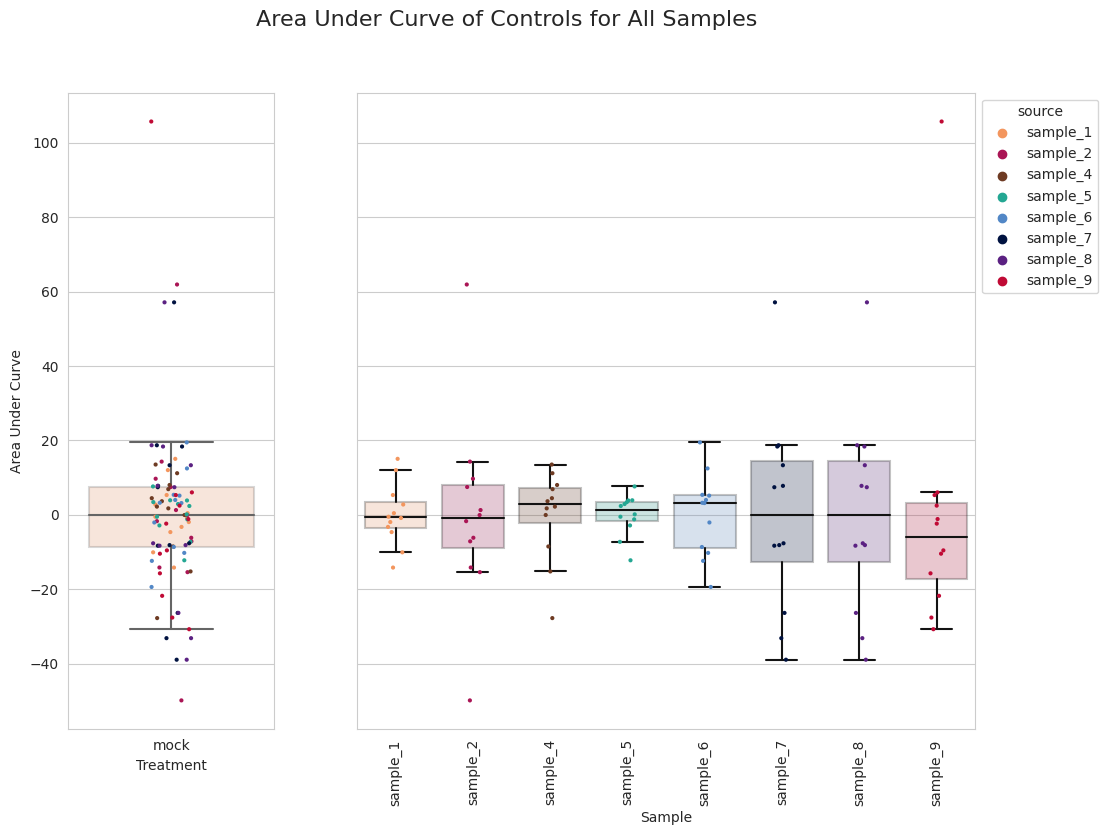

In [6]:
control_normalized_controls = control_normalized.filter((pl.col("treatment") == "mock"))
control_aucs = analyses.area_under_curve_by_sample(control_normalized_controls)
metadata = dataset.drop(["rlu", "time"]).unique()
control_aucs = control_aucs.join(metadata, on="sample_id")
control_aucs = control_aucs.sort(["source", "row", "position"])
fig, ax = plots.control_auc_box_pair(control_aucs)


## Facet grid of individual plates

The code below generates a visual representation of the normalized timeseries of a single plate.
Refer to the table of unique `source` values and amend the code to inspect each plate separately. 

In [7]:
print("Select a value from the table below to put into the `SAMPLE` variable in the next block")
control_normalized["source"].unique()

Select a value from the table below to put into the `SAMPLE` variable in the next block


source
str
"""sample_9"""
"""sample_6"""
"""sample_4"""
"""sample_2"""
"""sample_1"""
"""sample_8"""
"""sample_7"""
"""sample_5"""


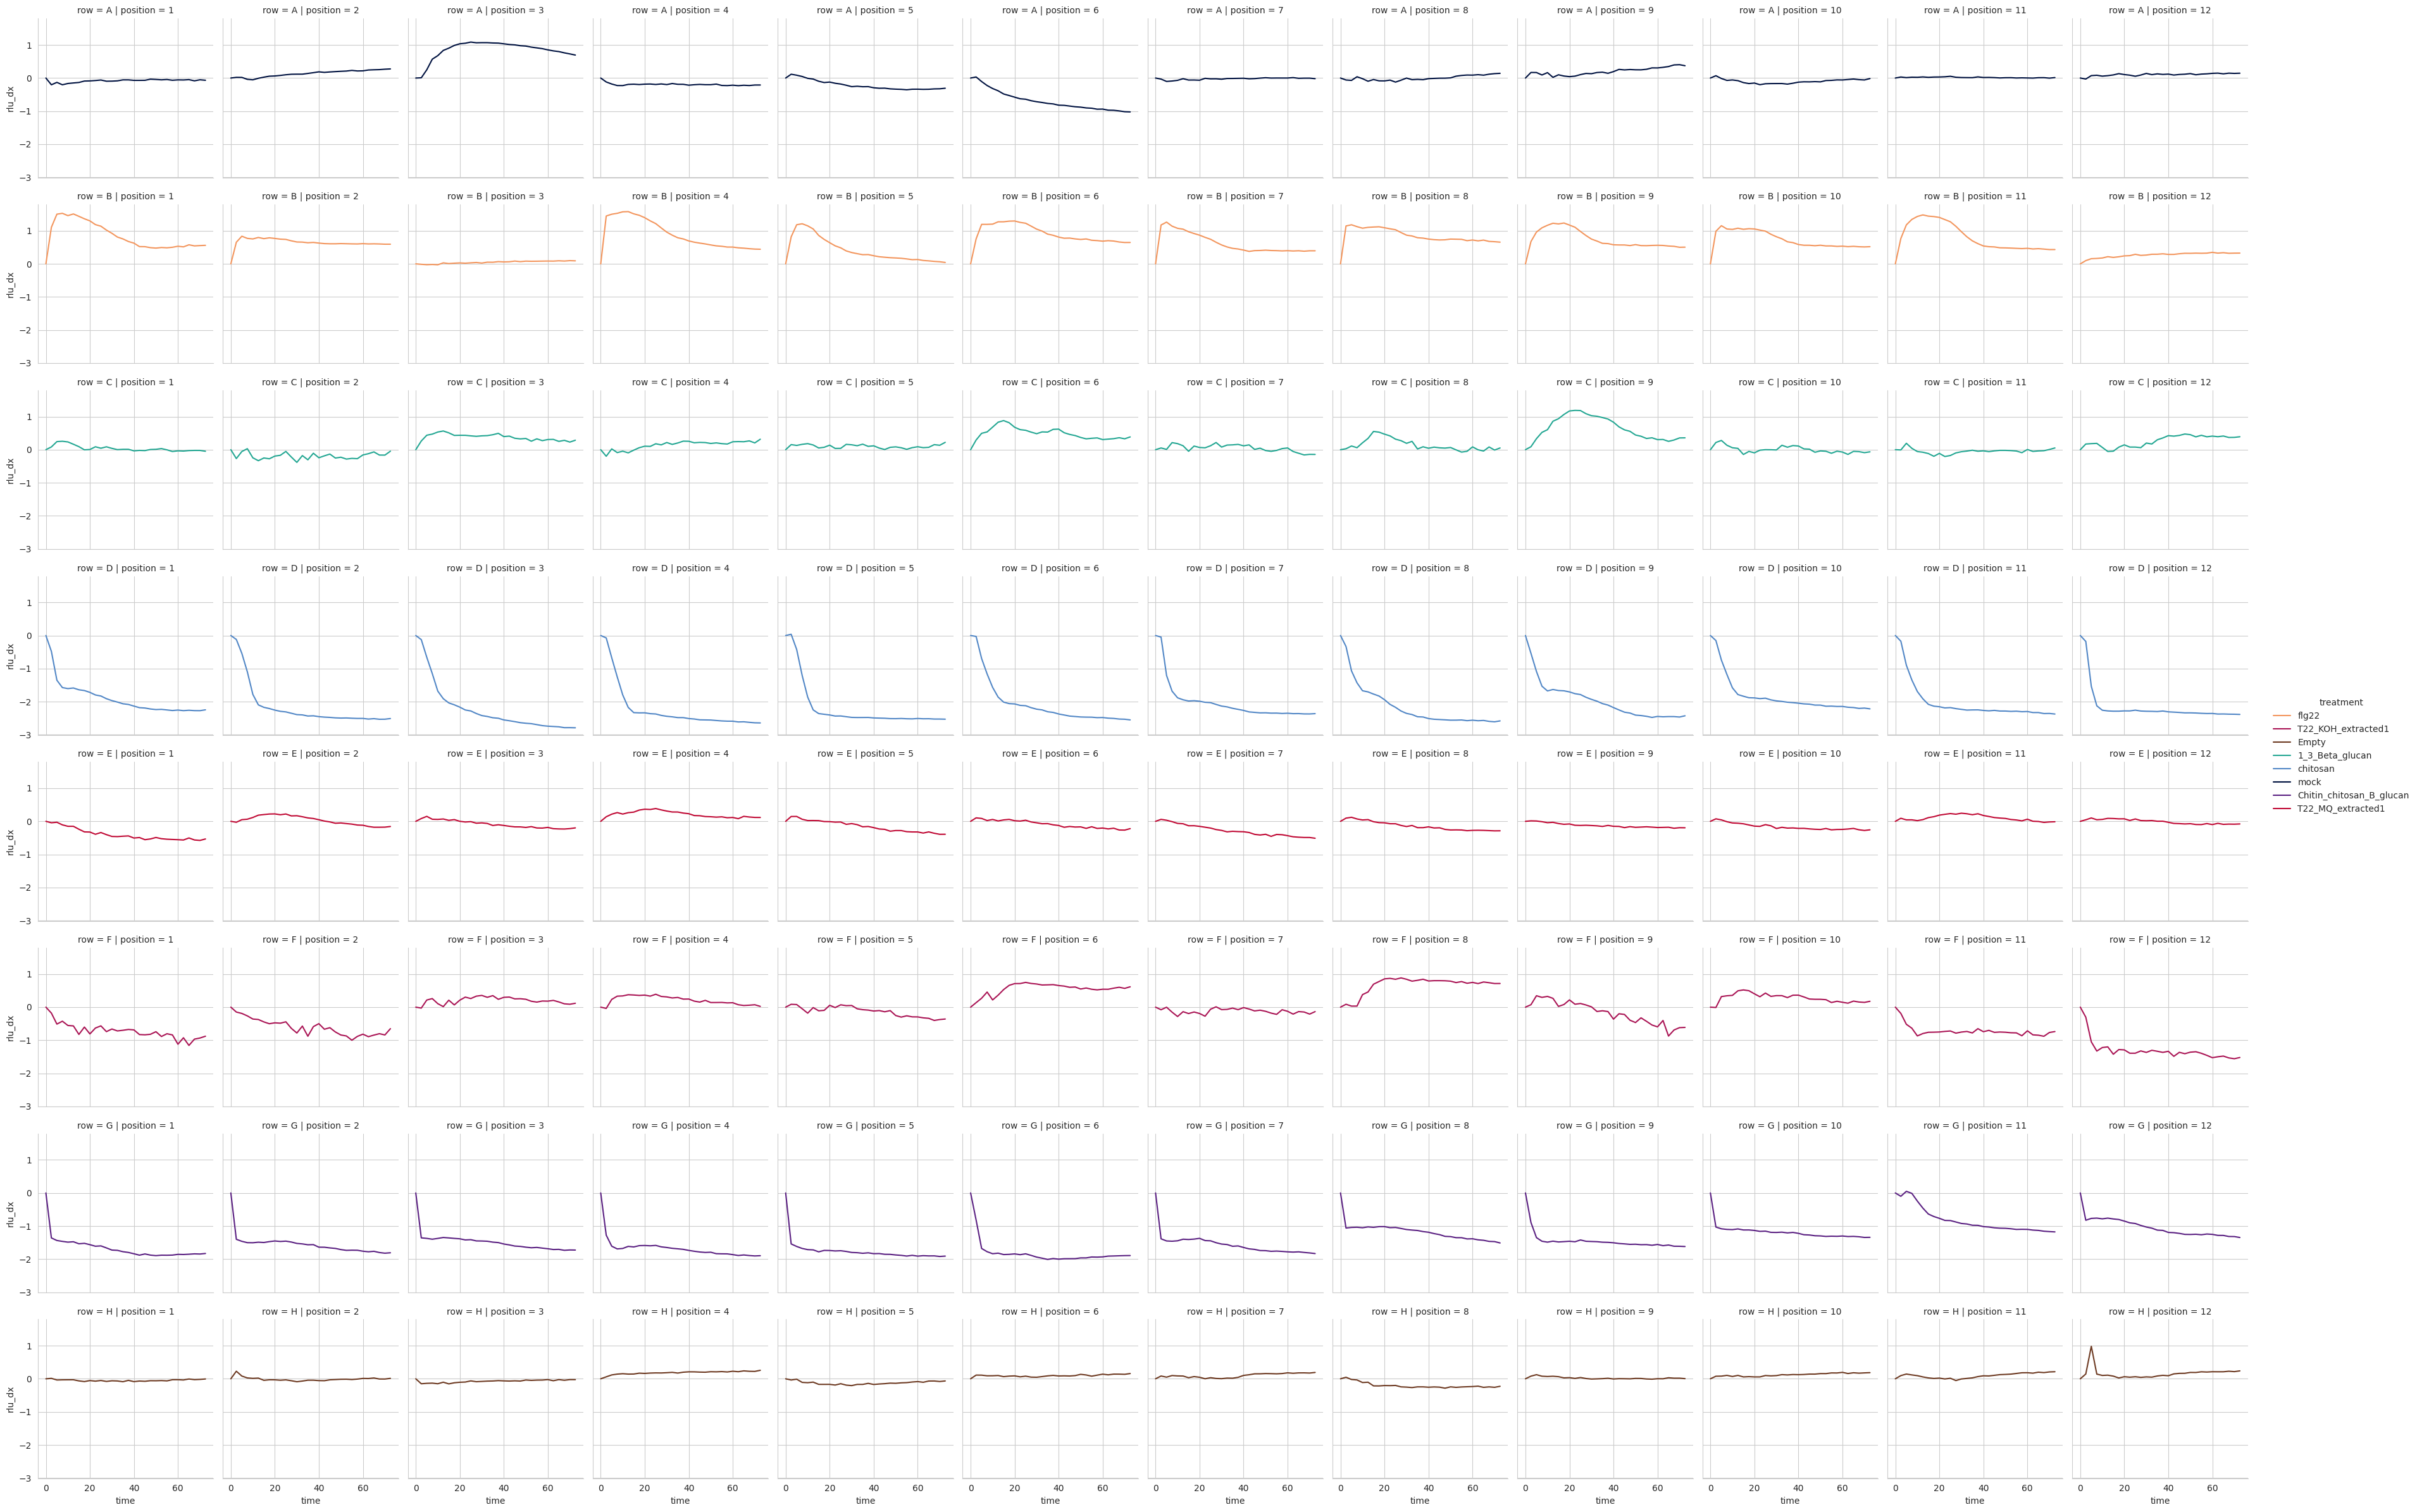

In [8]:
SAMPLE = "sample_2"

sample_df = control_normalized.filter(pl.col("source") == SAMPLE)
sample_df.sort(["row", "position", "time"])

grid = plots.plate_grid_timeseries(sample_df)

# Statistical Analysis and Custom Figures

With the given evaluation methodology, the code block below can be used to filter out values.
It is recommended to document why you choose to remove certain values or to exclude specific experiments.

In [9]:
# process control_normalized here into a clean_df

clean_df = control_normalized

# Area Under Curve plot

The following code block generates a boxplot with all treatments that you choose to include. 
To keep the plot readable, it is advised to keep the amount of treatments under 8.

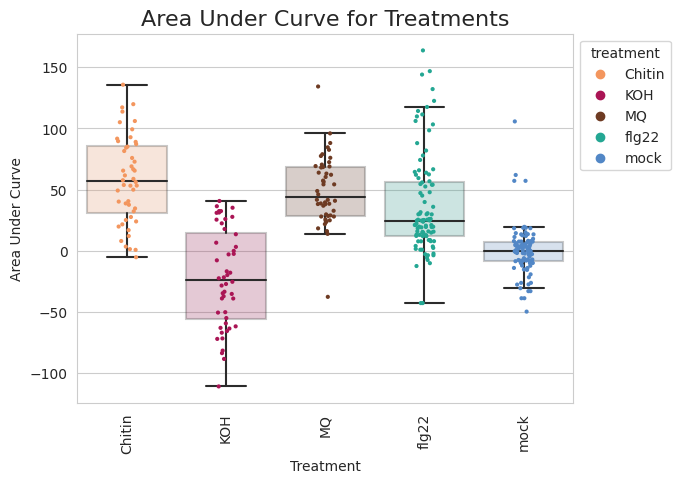

In [11]:
TREATMENTS = [
    "mock",
    "flg22",
    "Chitin",
    "KOH",
    "MQ"
]

auc_box_df = clean_df.filter(pl.col("treatment").is_in(TREATMENTS))
auc_box_df = analyses.area_under_curve_by_sample(auc_box_df)
auc_box_df = (
    auc_box_df
    .join(metadata, on="sample_id")
    .sort([(pl.col("treatment") == "mock"), "treatment"])
)
auc_box = plots.auc_boxplot(auc_box_df)